# Interpreting Tree Models

You'll need to install the `treeinterpreter` library. 

In [9]:
#!pip install treeinterpreter

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

from treeinterpreter import treeinterpreter as ti

from IPython.display import Image

## For Regression task

Load the Boston Housing dataset.

In [11]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
df = pd.concat((df_train_features, df_train_labels), axis=1)

In [12]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [13]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

X = df[num_vars + cat_vars]

# Label
y = df['MEDV']

# Create dataset
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

#### Visualizing a Decision Tree

You will need to install the `pydotplus` library.

In [18]:
#!pip install pydotplus

In [19]:
import pydotplus

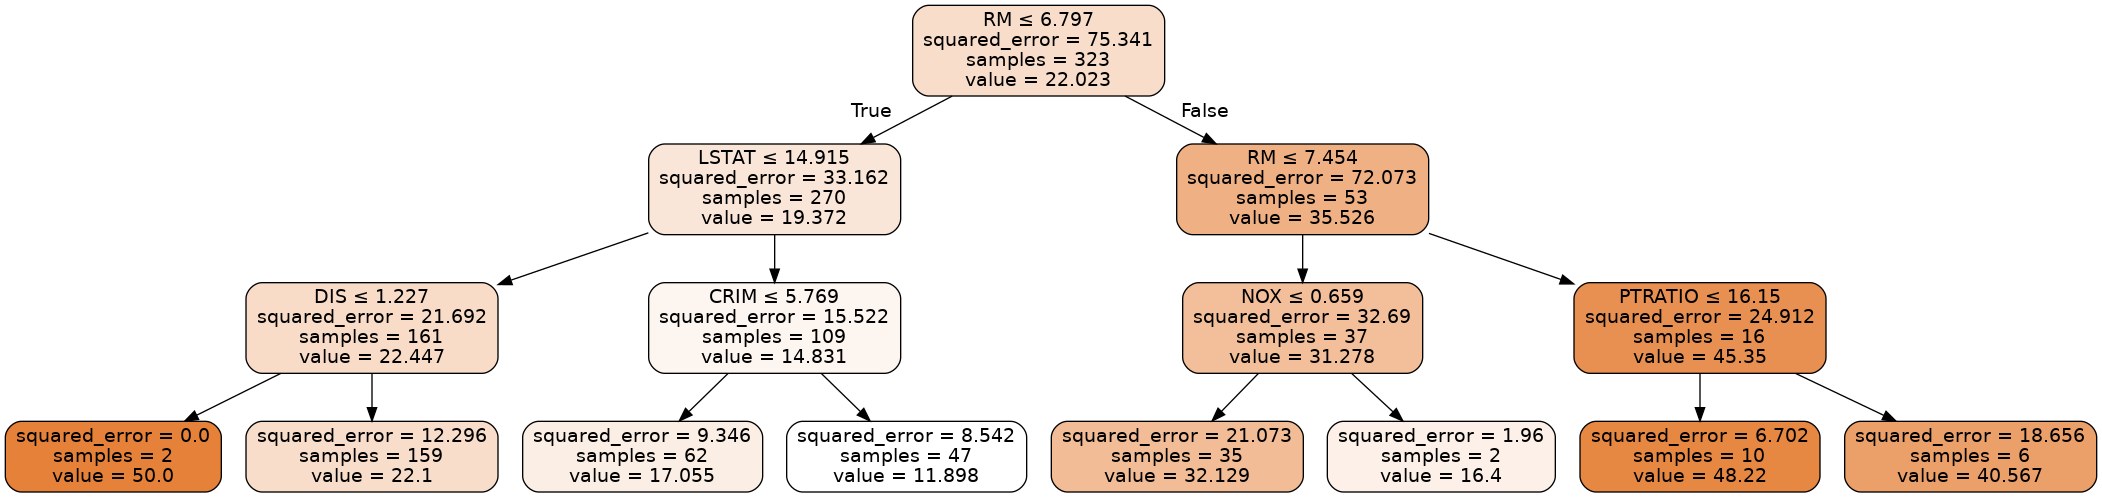

In [20]:
dt_reg = DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X_train, y_train)

dot_data = export_graphviz(dt_reg, out_file="boston.dot",
                           feature_names=num_vars + cat_vars,
                           filled=True, rounded=True,
                           special_characters=True,
                           leaves_parallel=False)
graph = pydotplus.graphviz.graph_from_dot_file("boston.dot")
Image(graph.create_png())

Make a sample prediction.

In [107]:
X_test[num_vars + cat_vars].iloc[[0]].transpose()

,275
CRIM,0.1676
ZN,0.0000
INDUS,7.3800
NOX,0.4930
RM,6.4260
AGE,52.3000
DIS,4.5404
RAD,5.0000
TAX,287.0000
PTRATIO,19.6000


In [104]:
dt_reg.predict(X_test[num_vars + cat_vars].iloc[[0]])

array([22.1])

The root node is the mean of the labels from the training data.

In [110]:
y_train.mean()

22.02291021671826

#### Train a simple Random Forest

In [68]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [69]:
print(f'Instance 11 prediction: {rf_reg.predict(X_test.iloc[[11]])}')
print(f'Instance 17 prediction: {rf_reg.predict(X_test.iloc[[17]])}')

Instance 11 prediction: [19.022]
Instance 17 prediction: [29.482]


In [117]:
idx = 11
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(rf_reg,
                                             X_test.iloc[[idx]].values)
print(f'prediction: {prediction}')
print(f'bias: {bias}')
print(f'contributions: {contributions}')

prediction: [[19.022]]
bias: [22.00703715]
contributions: [[ 0.04519352  0.00355101 -0.23264379 -0.25996203 -2.82079661  0.15005513
  -0.45287151  0.06638079 -0.50999526 -0.32155832  0.10541407  1.24676009
  -0.00456425]]


In [120]:
for idx in [11, 17]:
    print(f'Instance: {idx}')
    prediction, bias, contributions = ti.predict(rf_reg,
                                                 X_test.iloc[[idx]].values)
    print(f'Bias term (training set mean): {bias}')
    print(f'Feature contributions:')
    for contribution, feature in sorted(zip(contributions[0],
                                            num_vars + cat_vars),
                                        key=lambda x: -abs(x[0])):
        print(feature, round(contribution, 2))
    print('-'*20) 

Instance: 11
Bias term (training set mean): [22.00703715]
Feature contributions:
RM -2.82
LSTAT 1.25
TAX -0.51
DIS -0.45
PTRATIO -0.32
NOX -0.26
INDUS -0.23
AGE 0.15
B 0.11
RAD 0.07
CRIM 0.05
CHAS -0.0
ZN 0.0
--------------------
Instance: 17
Bias term (training set mean): [22.00703715]
Feature contributions:
LSTAT 6.73
DIS 1.43
RM -0.97
AGE -0.53
B 0.52
RAD 0.51
PTRATIO -0.13
INDUS -0.13
TAX 0.09
NOX -0.07
CHAS 0.02
ZN -0.0
CRIM -0.0
--------------------


In [71]:
idx = 17
prediction, bias, contributions = ti.predict(rf_reg, X_test.iloc[[idx]].values)
print(f'prediction: {prediction[0]}')
print(f'bias + contributions: {bias + np.sum(contributions)}')

prediction: [29.482]
bias + contributions: [29.482]


In fact, we can check that this holds for all elements of the test set:

In [73]:
predictions, biases, contributions = ti.predict(rf_reg, X_test.values)

assert(np.allclose(np.squeeze(predictions), biases + np.sum(contributions, axis=1)))
assert(np.allclose(rf_reg.predict(X_test), biases + np.sum(contributions, axis=1)))

## Comparing Contributions across data slices

In [74]:
X1_test = X_test[:X_test.shape[0]//2:]
X2_test = X_test[X_test.shape[0]//2:]

In [75]:
predictions1, biases1, contributions1 = ti.predict(rf, X1_test.values)
predictions2, biases2, contributions2 = ti.predict(rf, X2_test.values)

In [76]:
total_contribs1 = np.mean(contributions1, axis=0) 
total_contribs2 = np.mean(contributions2, axis=0) 

print(f'Total contributions from X1_test: {total_contribs1}')
print(f'Total contributions from X2_test: {total_contribs2}')

print(f'Sum of feature contributions differences: {np.sum(total_contribs1 - total_contribs2)}')
print(f'Difference between the average predictions: {np.mean(predictions1) - np.mean(predictions2)}')

Total contributions from X1_test: [-0.23751662 -0.01780879 -0.0860547   0.09580208 -0.29083984 -0.04938428
 -0.01448629  0.0101441  -0.10531179 -0.13878179  0.05993223  0.38907409
 -0.00585647]
Total contributions from X2_test: [-0.38653223  0.01122983 -0.02520486 -0.04845029  1.98003087  0.06388986
 -0.20451076  0.01199877 -0.09613802 -0.11006763  0.0059582   0.85999232
 -0.00969513]
Sum of feature contributions differences: -2.4435890243902447
Difference between the average predictions: -2.4435890243902456


## TreeExplainer with SHAP

In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [22]:
import xgboost as xgb
xgb_reg = xgb.XGBClassifier(max_depth=3,
                            n_estimators=300,
                            learning_rate=0.05)
xgb_reg.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:15:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
model_mse_error = np.sqrt(np.mean((xgb_reg.predict(X_test) - y_test)**2))
print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 6.05303719295192


In [30]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value[1],
                shap_values[1][0,:],
                X_train.iloc[0,:])

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train.iloc[:1000,:])

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License